In [1]:
import numpy as np
# import numpy.ma as ma
import pandas as pd
# import netCDF4
# import matplotlib as mpl
from matplotlib import rcParams
from matplotlib import pyplot as plt
# import statistics as sta
import xarray as xr
rcParams["font.size"] = 15

In [2]:
# from netCDF4 import Dataset

# ds = Dataset("ACEFTS_L2_v5p3_O3.nc", "r+")

# if "index" not in ds.variables:
#     prof_var = ds.createVariable("index", "i4", ("index",))
# else:
#     prof_var = ds.variables["index"]

# prof_var[:] = range(132257)
# ds.close()


In [ ]:
f = xr.open_dataset("ACEFTS_L2_v5p3_O3.nc")

#get orbit num and sunrise/sunset num
orbits  = f.variables["orbit"][:].values.astype(int)
ss  = f.variables["sunset_sunrise"][:].values.astype(int)

#get orbit num and sunrise/sunset num for flags
flag_file = r"C:\Users\salla\Onedrive(uoft acc)\OneDrive - University of Toronto\Desktop\School Information\NSERC\NSERC\O3 Analysis\ACEFTS\ACEFTS_L2_v5p3_flags_Apr2025\ACEFTS_L2_v5p3_flags_O3.nc"
f_flags     = xr.open_dataset(flag_file)
flags       = f_flags["quality_flag"][:]
orbits_flags    = f_flags.variables["orbit"][:].values.astype(int)
ss_flags    = f_flags.variables["sunset_sunrise"][:].values.astype(int)

#get flags for only the unique orbit num and sunrise/sunset combinations
combined_flags = np.column_stack((orbits_flags, ss_flags))
unique_flags, returned_index, returned_counts = np.unique(combined_flags, axis=0, return_index = True, return_counts = True)
returned_index = returned_index[returned_counts == 1]
unique_flags = combined_flags[np.sort(returned_index)]

#dataframe of flags and indices
flag_matcher = pd.DataFrame({
    "matcher_col": [tuple(row) for row in unique_flags],
    "flag_idx": np.sort(returned_index)
})
flag_matcher.set_index("matcher_col", inplace = True)

#dataframe of data and indices
matcher = pd.DataFrame()
matcher["matcher_col"] = [tuple(row) for row in np.column_stack((orbits, ss))]
matcher.reset_index(inplace = True)
matcher.set_index("matcher_col", inplace = True)


matched = pd.merge(matcher, flag_matcher, how = "inner", left_index = True, right_index = True)
matched = matched.sort_values("index")
flags = flags[matched["flag_idx"], :].T
valid_indices = matched["index"].values

f = f.isel(index = valid_indices)

In [4]:
time = pd.to_datetime({"year": f.variables["year"], "month": f.variables["month"], "day": f.variables["day"], "hour": f.variables["hour"]})

f = (f.assign_coords(
    time=("index", time),
    latitude = ("index", f.variables["latitude"]),
    longitude = ("index", f.variables["longitude"])
    )     
    .swap_dims({"index": "time"})
    .sortby("time"))

sorted_time = f.time

flags_sorted = (
    flags
    .assign_coords(time=("index", time))
    .swap_dims({"index": "time"})
    .sel(time=sorted_time)
)

In [5]:
O3 = f["O3"].T.where(flags_sorted == 0)
temperature = f["temperature"][:].T.where(flags_sorted == 0)
pressure = f["pressure"][:].T.where(flags_sorted == 0)
O3_density = O3 * (pressure/(8.3145 * temperature))

In [6]:
O3_times = O3.sel(time = slice("2006-01-01", "2020-12-31"))

C:\Users\salla\AppData\Local\Temp\ipykernel_8852\3522266909.py:23: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  pcm_seasonal.axes.flat[0].set(ylabel = "Altitude (km)")
C:\Users\salla\AppData\Local\Temp\ipykernel_8852\3522266909.py:24: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  pcm_seasonal.axes.flat[2].set(ylabel = "Altitude (km)")
C:\Users\salla\AppData\Local\Temp\ipykernel_8852\3522266909.py:25: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  pcm_seasonal.axes.flat[3].set(xlabel = "Latitude (N)")
C:\Users\salla\AppData\Local\Temp\ipykernel_8852\3522266909.py:26: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  pcm_seasonal.axes.flat[2].set(xlabel = "L

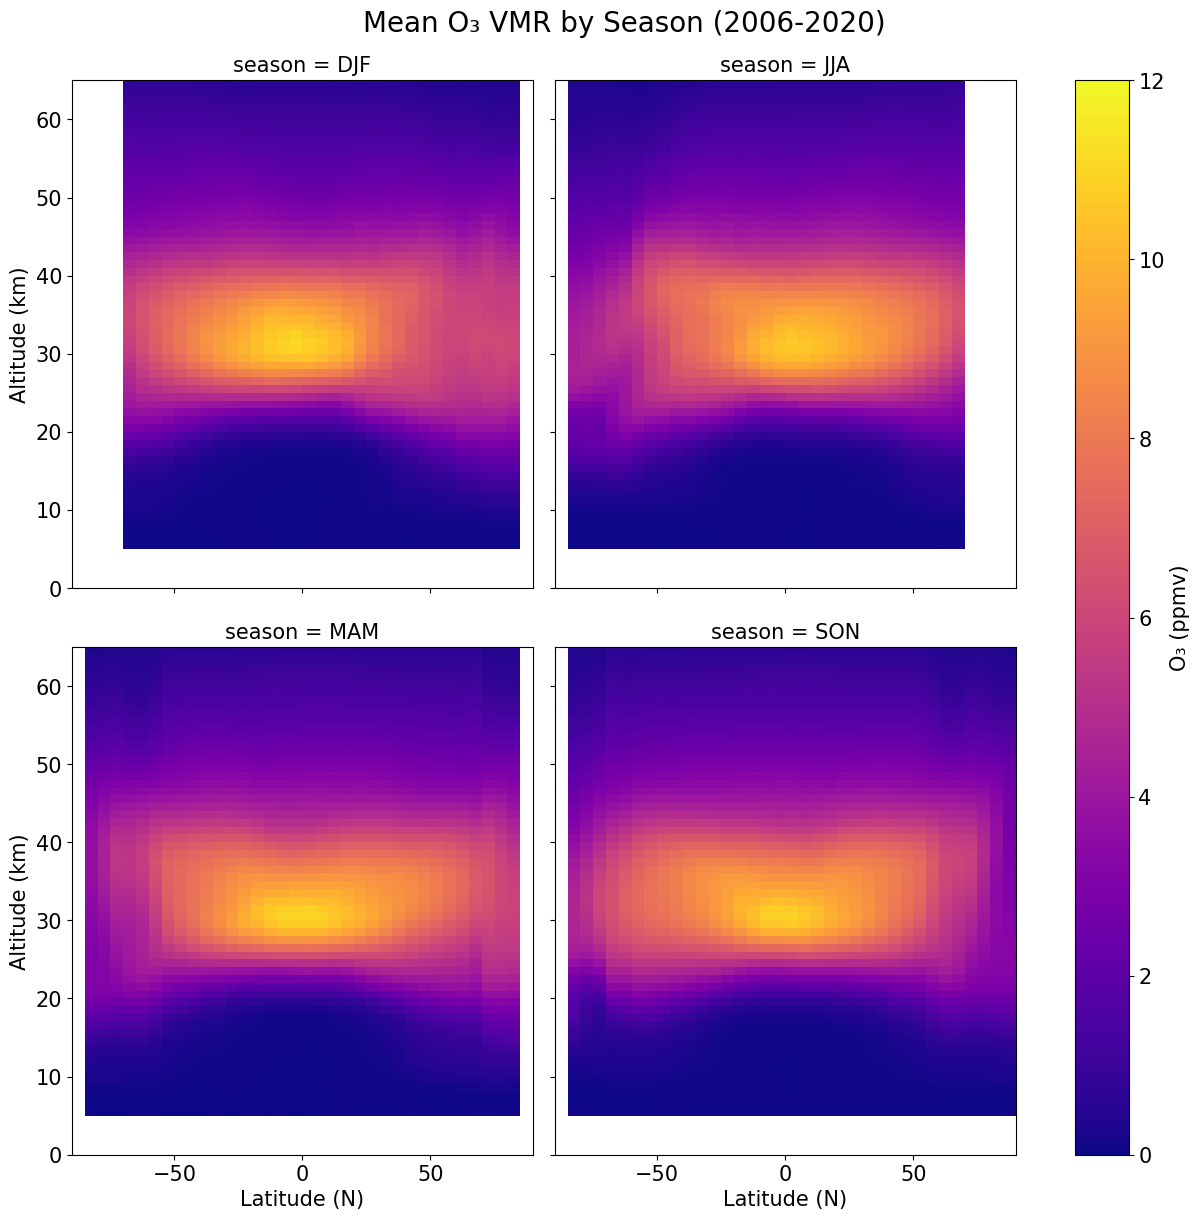

In [7]:
def seasonal_lat_binner(O3_season):
    lat_bins = np.arange(-90,91,5)
    binned = O3_season.groupby_bins(O3_season["latitude"], lat_bins).mean(dim = "time")
    return binned
O3_seasons = O3_times.groupby("time.season").map(seasonal_lat_binner)

pcm_seasonal = (O3_seasons * 10**6).plot(size= 6, 
                                col = "season",
                                 col_wrap = 2, 
                                 cmap = "plasma", 
                                 x="latitude_bins", 
                                 y = "altitude", 
                                 vmin = 0, 
                                 vmax = 1.2 * (10 ** -5)  * 10**6,
                                 cbar_kwargs={"label": "O₃ (ppmv)"})

plt.suptitle(
    "Mean O₃ VMR by Season (2006-2020)",
    fontsize=20,
    y=1.02
)

pcm_seasonal.axes.flat[0].set(ylabel = "Altitude (km)")
pcm_seasonal.axes.flat[2].set(ylabel = "Altitude (km)")
pcm_seasonal.axes.flat[3].set(xlabel = "Latitude (N)")
pcm_seasonal.axes.flat[2].set(xlabel = "Latitude (N)")

fig = pcm_seasonal.fig
title = fig._suptitle.get_text()
fig.savefig(title, bbox_inches="tight")

for ax in pcm_seasonal.axes.flat:
    ax.set_ylim(0, 65)

C:\Users\salla\AppData\Local\Temp\ipykernel_8852\2140848201.py:14: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for i, ax in enumerate(pcm_monthly.axes.flat):
C:\Users\salla\AppData\Local\Temp\ipykernel_8852\2140848201.py:23: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  pcm_monthly.axes.flat[0].set(ylabel = "Altitude (km)")
C:\Users\salla\AppData\Local\Temp\ipykernel_8852\2140848201.py:24: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  pcm_monthly.axes.flat[9].set(ylabel = "Altitude (km)")
C:\Users\salla\AppData\Local\Temp\ipykernel_8852\2140848201.py:25: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  pcm_monthly.axes.flat[6].set(ylabel = "Altitude (km

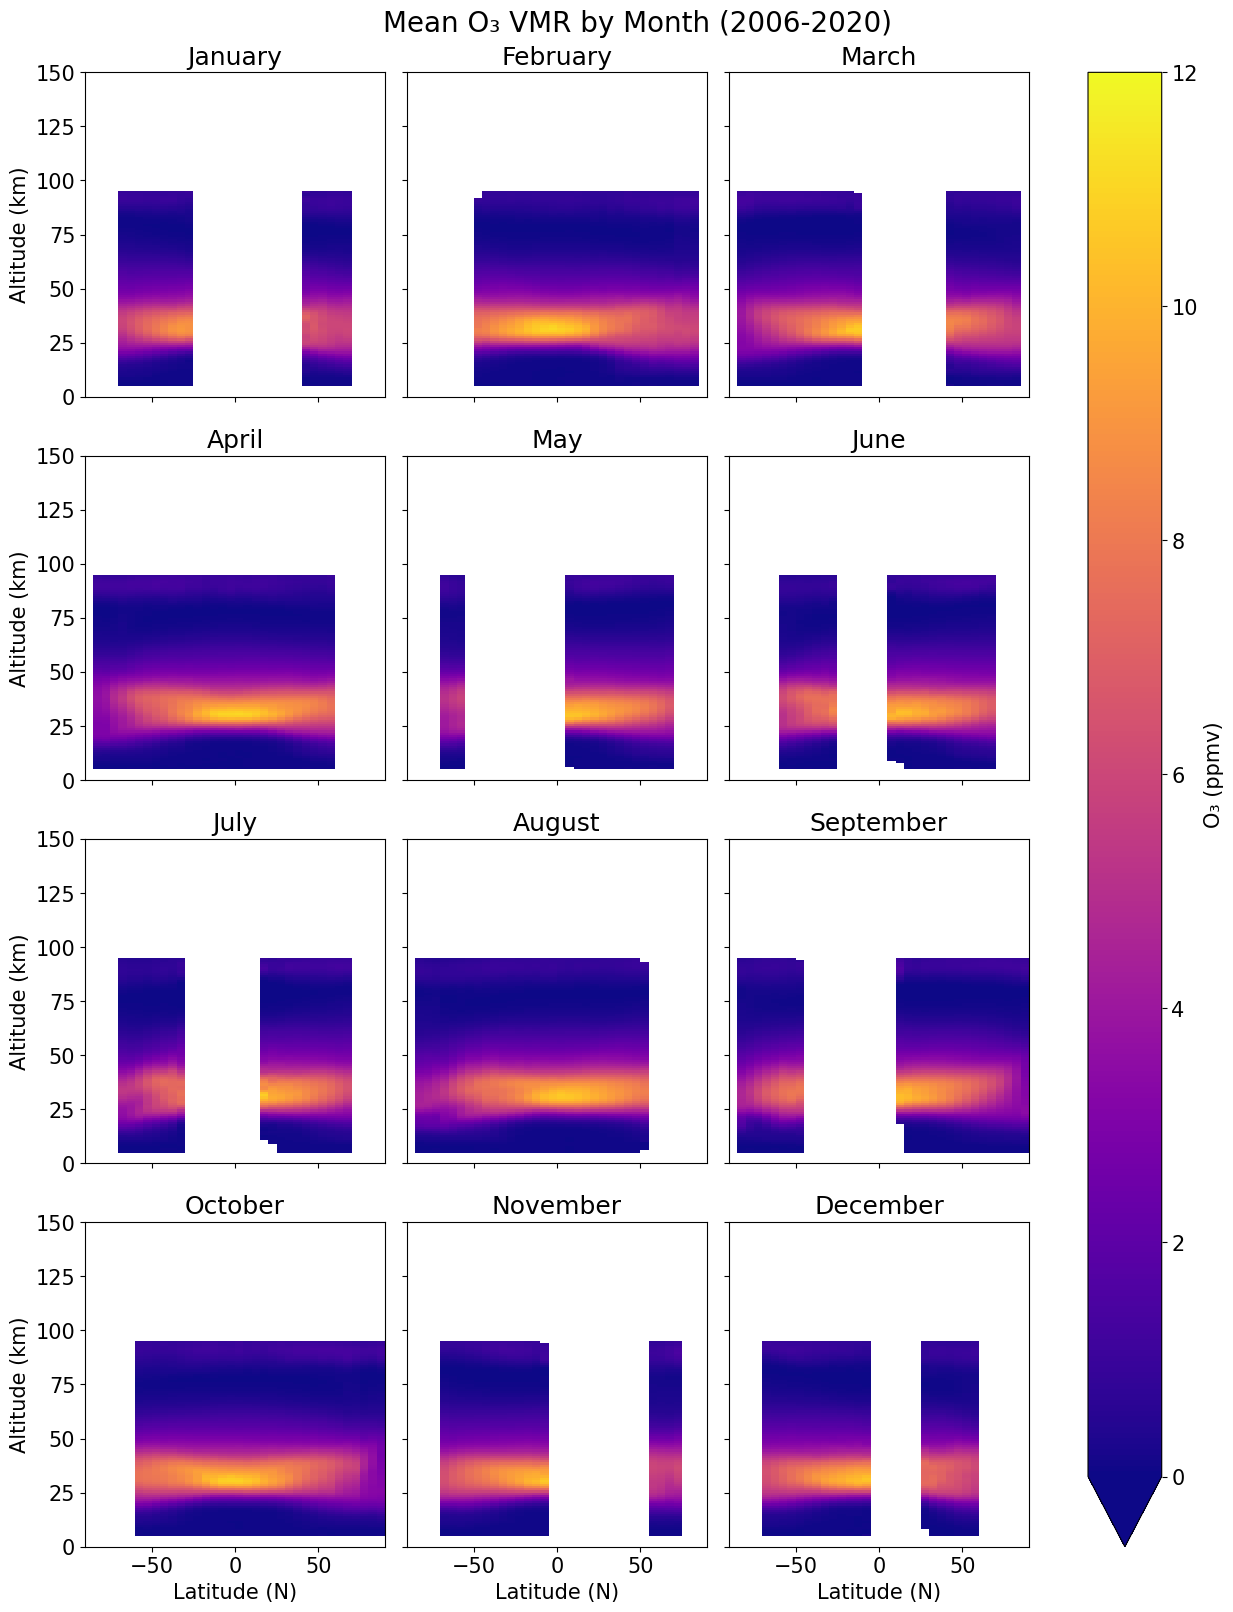

In [8]:
start_2006 = "2006-01-01"
end_2020   = "2020-12-31"
lat_bins = np.arange(-90,91,5)

def monthly_lat_binner(O3_month):
    binned = O3_month.groupby_bins(O3_month["latitude"], lat_bins).mean(dim = "time")
    return binned
O3_months = (O3_times * 10**6).groupby("time.month").map(monthly_lat_binner)

pcm_monthly = O3_months.plot(col = "month", col_wrap = 3, cmap = "plasma", size = 4,x="latitude_bins", y = "altitude",  vmin = 0, vmax = 1.2 * (10 ** -5) * 10**6, cbar_kwargs={"label": "O₃ (ppmv)"})

month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

for i, ax in enumerate(pcm_monthly.axes.flat):
    ax.set_title(month_names[i])

plt.suptitle(
    "Mean O₃ VMR by Month (2006-2020)", 
    fontsize=20,
    y=1.01
)

pcm_monthly.axes.flat[0].set(ylabel = "Altitude (km)")
pcm_monthly.axes.flat[9].set(ylabel = "Altitude (km)")
pcm_monthly.axes.flat[6].set(ylabel = "Altitude (km)")
pcm_monthly.axes.flat[3].set(ylabel = "Altitude (km)")
pcm_monthly.axes.flat[9].set(xlabel = "Latitude (N)")
pcm_monthly.axes.flat[10].set(xlabel = "Latitude (N)")
pcm_monthly.axes.flat[11].set(xlabel = "Latitude (N)")

fig = pcm_monthly.fig
title = fig._suptitle.get_text()
fig.savefig(title, bbox_inches="tight")

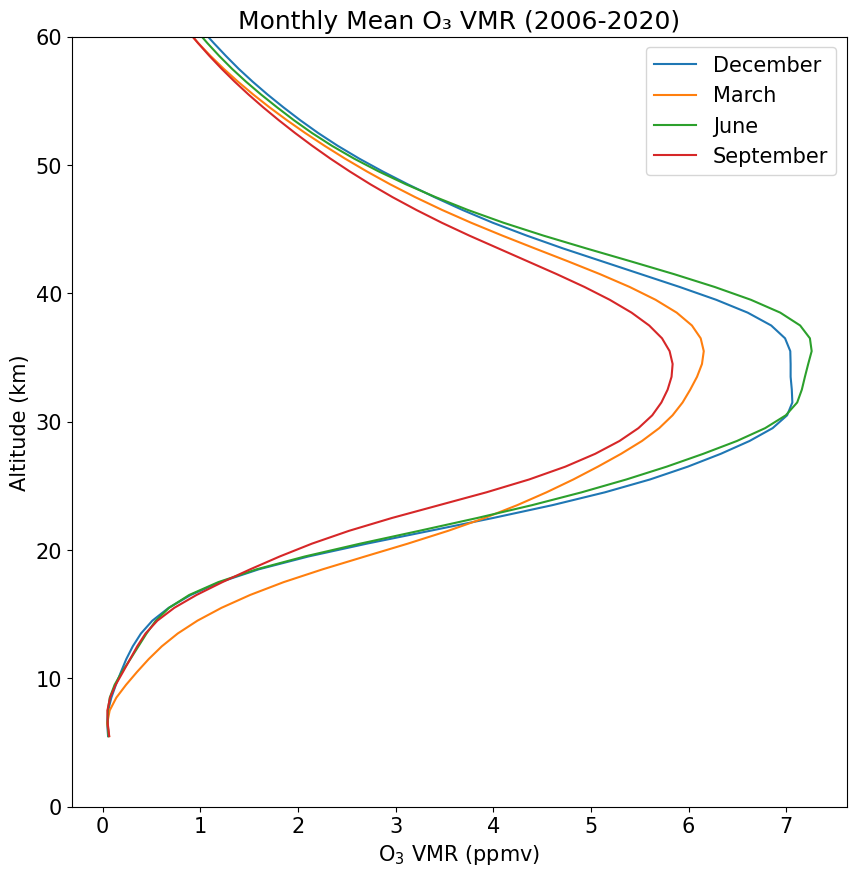

In [9]:
valid_months = [12,3,6,9]

month_name = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

fig, axes = plt.subplots(figsize = (10, 10))
for i in range(len(valid_months)):
    month_num = valid_months[i]
    O3_month = O3_times.sel(time = O3_times["time"].dt.month.isin([month_num]))
    (O3_month.mean(dim = "time") * 10**6).plot(ax = axes, label = f"{month_name[month_num - 1]}", y = "altitude")

plt.legend()

plt.title("Monthly Mean O₃ VMR (2006-2020)")
plt.ylabel("Altitude (km)")
plt.xlabel("O$_3$ VMR (ppmv)")

plt.ylim(0,60)
# fig = pcm_seasonal.fig
# title = fig._suptitle.get_text()
# fig.savefig(title, bbox_inches="tight")

title = axes.get_title()
fig.savefig(title, bbox_inches="tight")

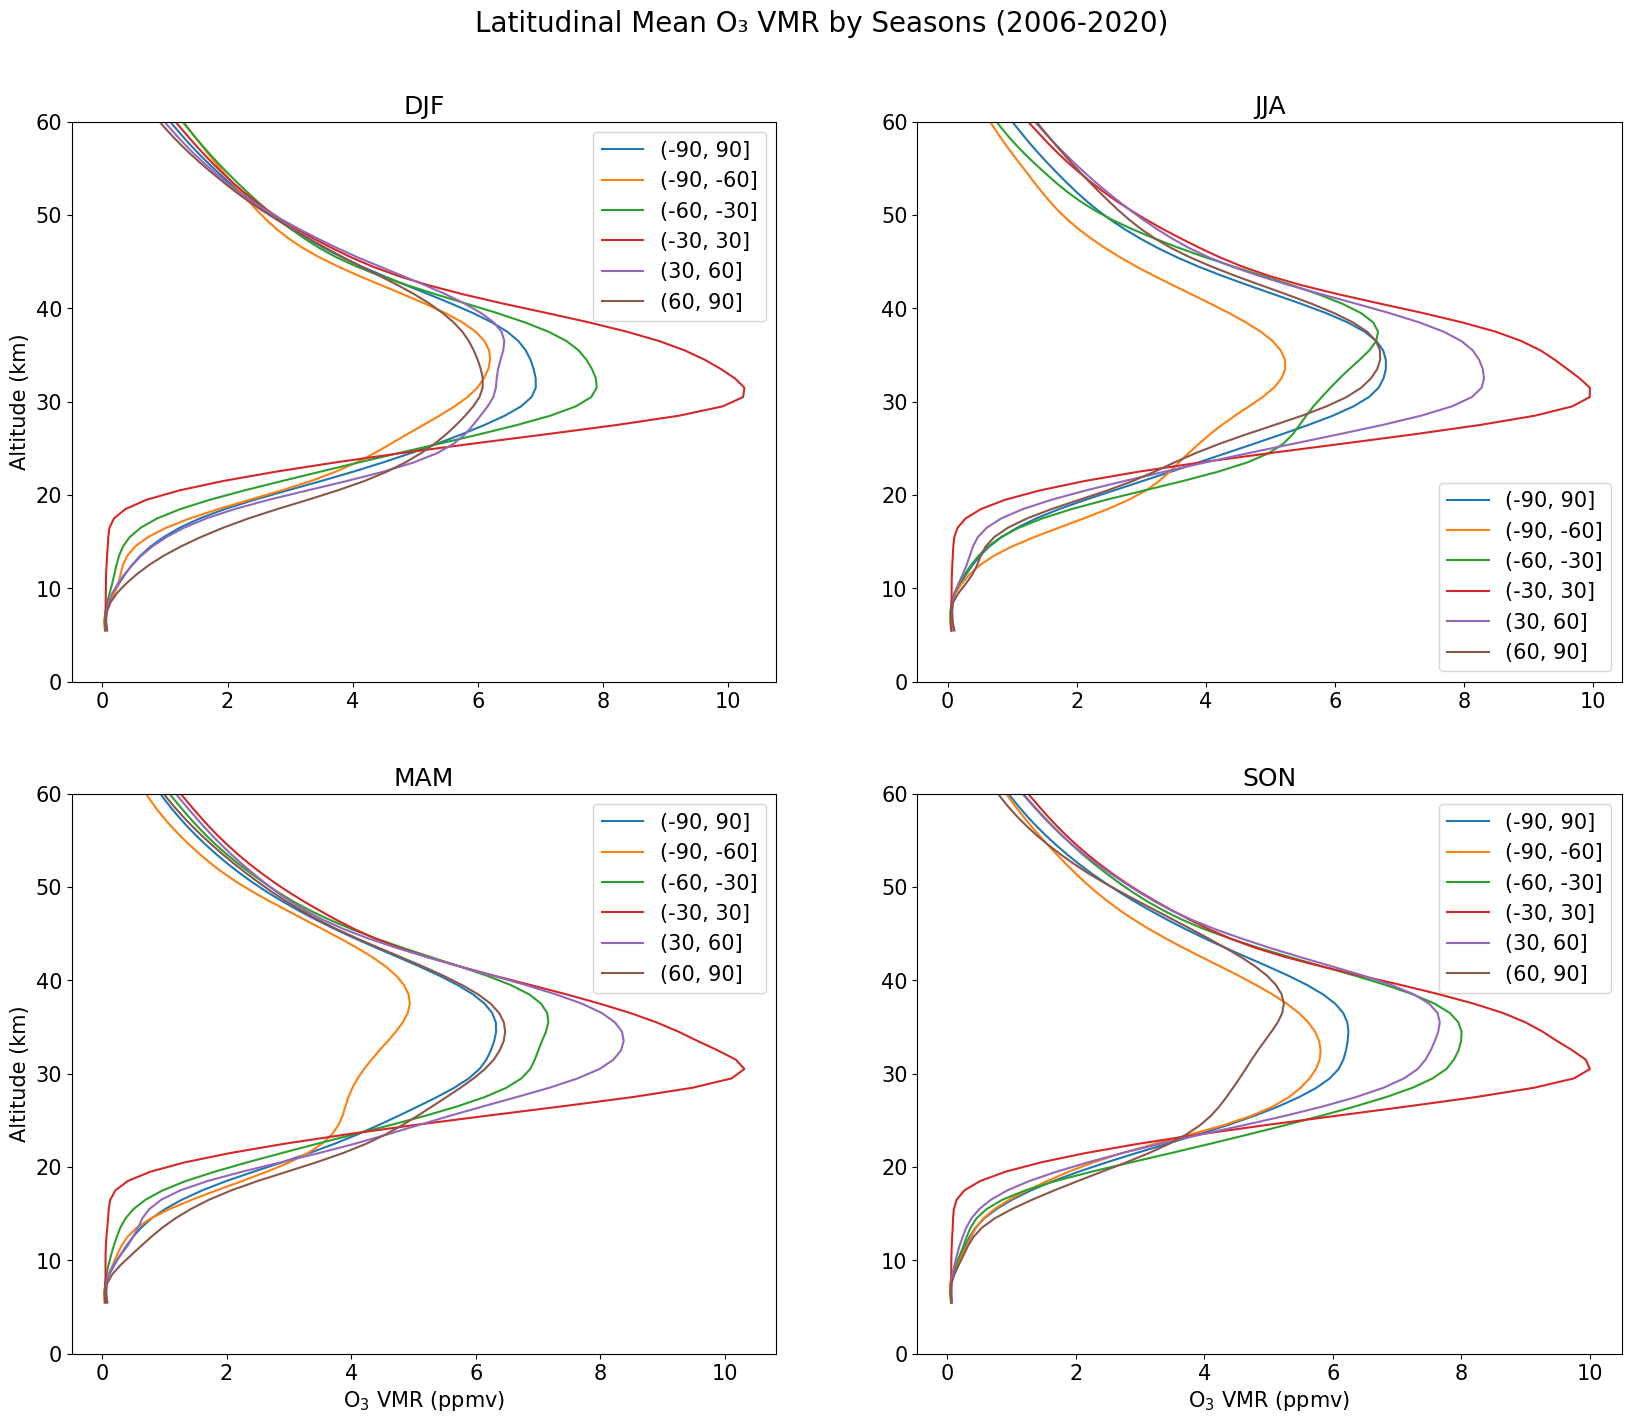

In [10]:
lat_bounds = [(-90,-60), (-60,-30), (-30,30), (30,60), (60,90), (-90,90)]
month_name = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

fig, axes = plt.subplots(2,2, figsize = (20,16))

def lat_binner(arr):
    lat_bins = [-90, -60, -30, 30, 60, 90]
    lat_binned = arr.groupby_bins("latitude", lat_bins).mean(dim = "time")
    return lat_binned

def global_binner(arr):
    lat_bins = [-90, 90]
    lat_binned = arr.groupby_bins("latitude", lat_bins).mean(dim = "time")
    return lat_binned


season_grouped = O3_times.groupby("time.season")
seasons = season_grouped.map(lat_binner)
global_seasons = season_grouped.map(global_binner)

for i, season in enumerate(global_seasons.season.values):
    seasonal = global_seasons.sel(season = season)
    for j, lat_bin in enumerate(global_seasons.latitude_bins.values):
        latitudinal = (seasonal.sel(latitude_bins = lat_bin) * 10**6).plot(ax = axes.flat[i], label = lat_bin, y = "altitude")

for i, season in enumerate(seasons.season.values):
    seasonal = seasons.sel(season = season)
    for j, lat_bin in enumerate(seasons.latitude_bins.values):
        latitudinal = (seasonal.sel(latitude_bins = lat_bin) * 10**6).plot(ax = axes.flat[i], label = lat_bin, y = "altitude")
    axes.flat[i].set(title = season)
    if i in [0, 1]:
        axes.flat[i].set(xlabel = None)
    if i in [1,3]:
        axes.flat[i].set(ylabel = None)
    axes.flat[i].legend()

plt.suptitle(
    "Latitudinal Mean O₃ VMR by Seasons (2006-2020)",
    fontsize=20,
    y=0.95
)

for ax in axes.flat:
    ax.set_ylim(0,60)
axes.flat[0].set(ylabel = "Altitude (km)")
axes.flat[2].set(ylabel = "Altitude (km)")
axes.flat[2].set(xlabel = "O$_3$ VMR (ppmv)")
axes.flat[3].set(xlabel = "O$_3$ VMR (ppmv)")

title = fig._suptitle.get_text()
fig.savefig(title, bbox_inches="tight")

In [11]:
O3_times.dims

('altitude', 'time')

<xarray.DataArray 'O3' (altitude: 150, latitude_bins: 5)> Size: 3kB
array([[           nan,            nan,            nan,            nan,
                   nan],
       [           nan,            nan,            nan,            nan,
                   nan],
       [           nan,            nan,            nan,            nan,
                   nan],
       [           nan,            nan,            nan,            nan,
                   nan],
       [           nan,            nan,            nan,            nan,
                   nan],
       [5.00280137e-08, 4.96901329e-08, 5.67656606e-08, 7.26689535e-08,
        7.84356899e-08],
       [3.50455380e-08, 4.24441708e-08, 5.67770648e-08, 6.49042846e-08,
        5.72118850e-08],
       [5.04349380e-08, 4.90130638e-08, 5.65421026e-08, 6.71623965e-08,
        6.96045461e-08],
       [9.50891916e-08, 7.31107903e-08, 5.75675259e-08, 9.13020770e-08,
        1.27647567e-07],
       [1.59414682e-07, 1.15125992e-07, 5.84384452e-08, 1.4

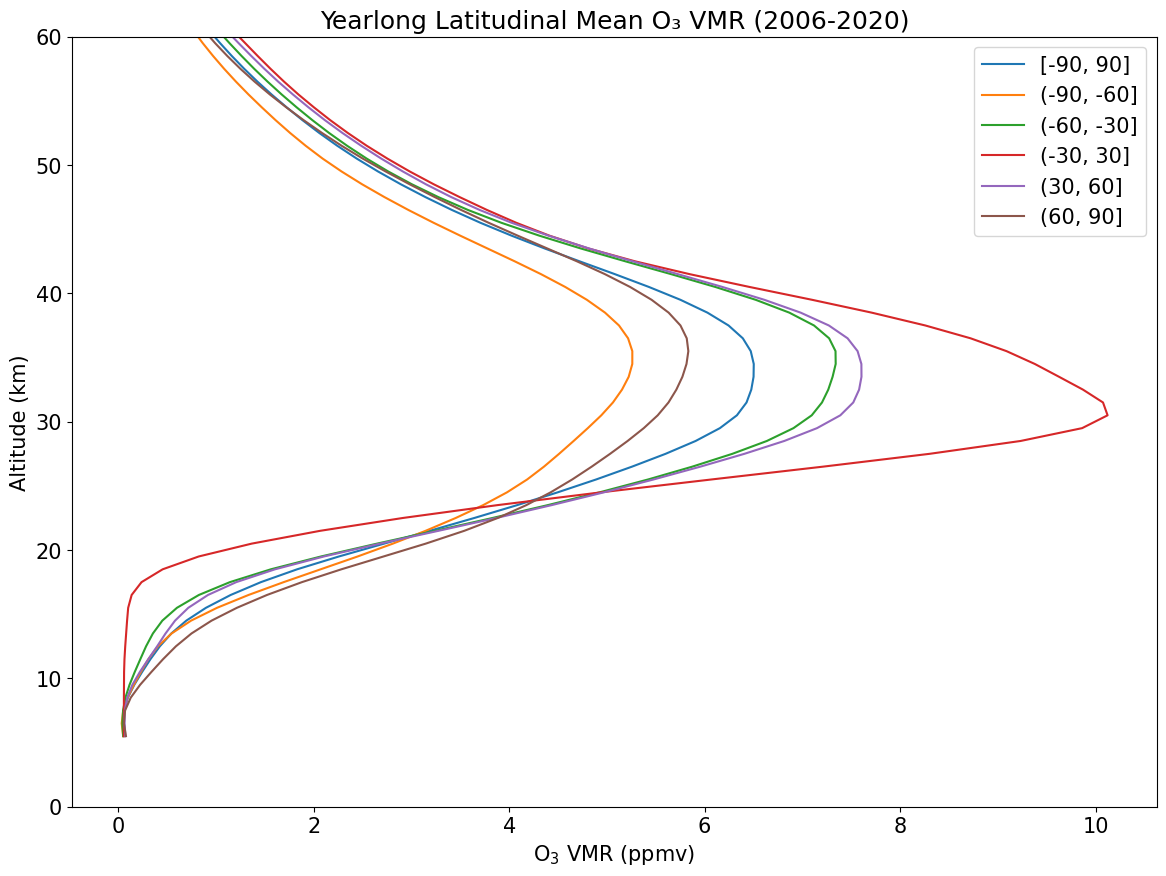

In [15]:
lat_bounds = [(-90,-60), (-60,-30), (-30,30), (30,60), (60,90), (-90,90)]
month_name = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

fig, axes = plt.subplots(figsize = (14,10))

def lat_binner(arr):
    lat_bins = [-90, -60, -30, 30, 60, 90]
    lat_binned = arr.groupby_bins("latitude", lat_bins).mean(dim = "time")
    return lat_binned

def global_binner(arr):
    lat_bins = [-90, 90]
    lat_binned = arr.groupby_bins("latitude", lat_bins).mean(dim = "time")
    return lat_binned

(O3_times.mean(dim = "time") * 10**6).plot(label = "[-90, 90]", y = "altitude", ax = axes)

print(lat_binner(O3_times))
for i, lat_bin in enumerate(lat_binner(O3_times).latitude_bins.values):
    (lat_binner(O3_times).sel(latitude_bins = lat_bin) * 10**6).plot(label = lat_bin, y = "altitude", ax = axes)

plt.title("Yearlong Latitudinal Mean O₃ VMR (2006-2020)")
plt.legend()

plt.ylabel("Altitude (km)")
plt.xlabel("O$_3$ VMR (ppmv)")
axes.set_ylim(0,60)
title = axes.get_title()
fig.savefig(title, bbox_inches="tight")

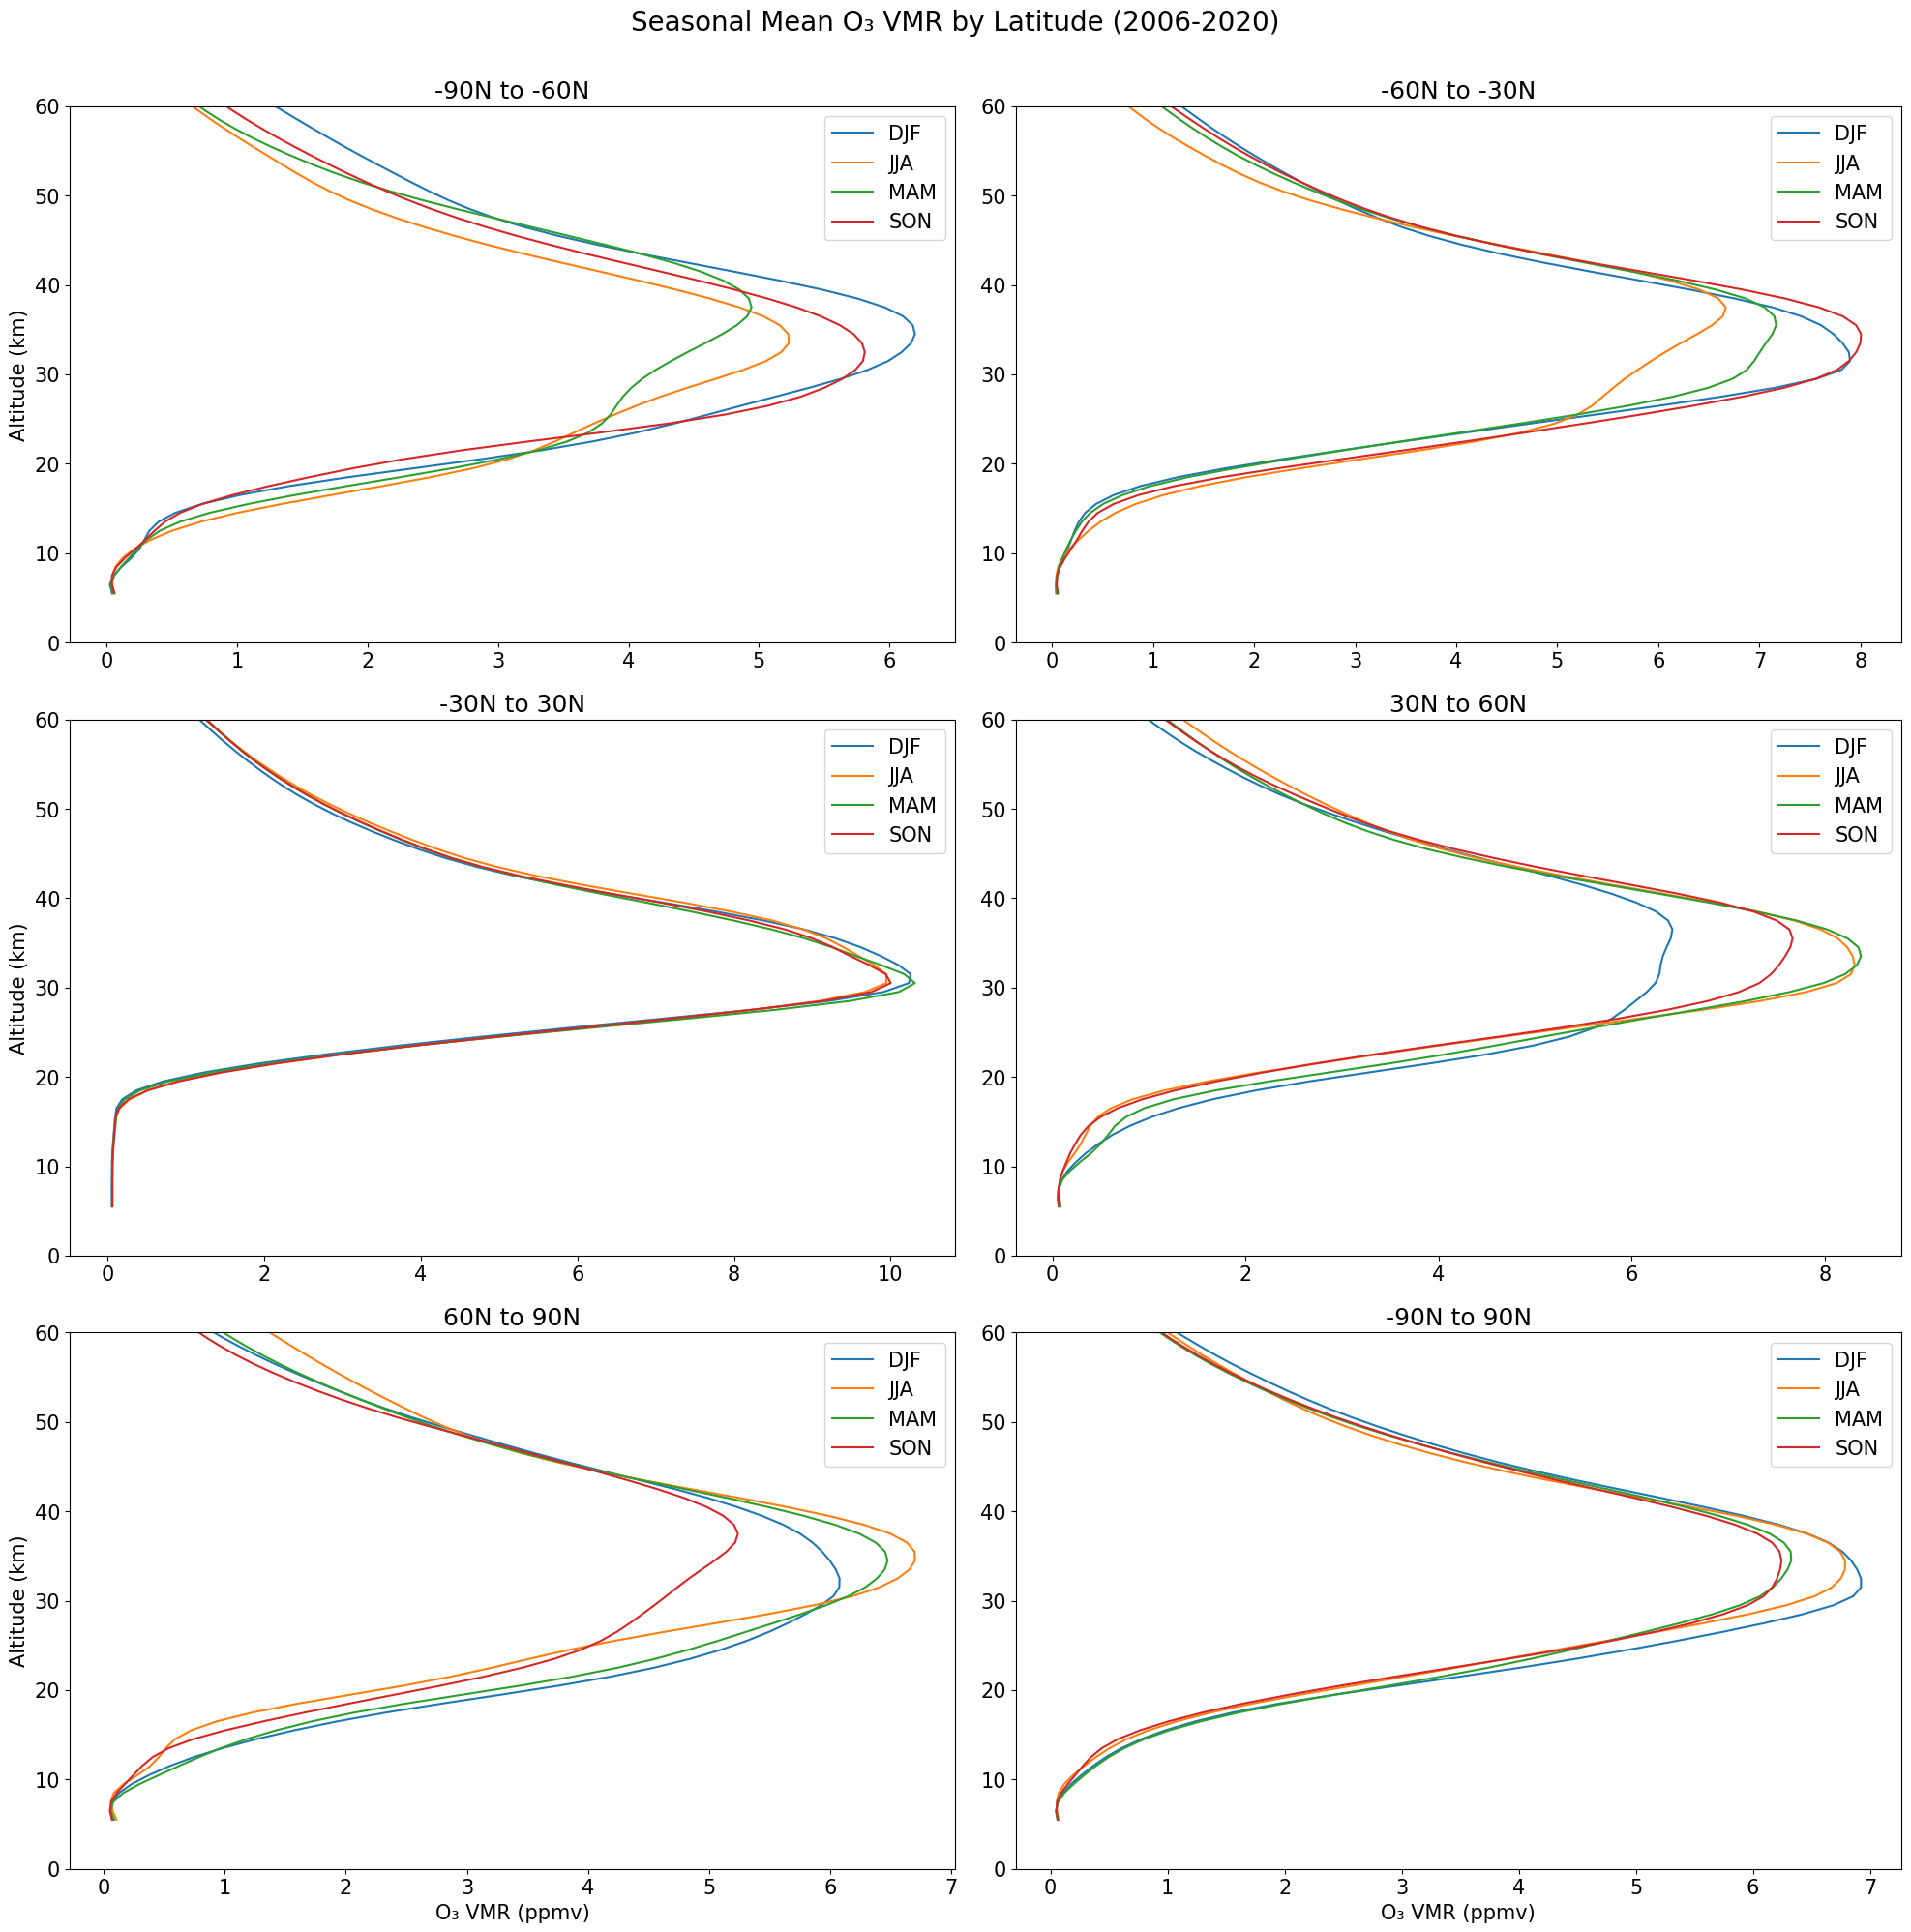

In [16]:
lat_bins = [-90, -60, -30, 30, 60, 90]
month_name = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

fig, axes = plt.subplots(3,2, figsize = (20,20))

def global_binner(arr):
    O3_seasonal = arr.groupby("time.season")
    for tup in O3_seasonal:
        axes.flat[5].plot(tup[1].mean(dim = "time"), tup[1]["altitude"], label = tup[0])
        axes.flat[5].set_title(f"-90N to 90N")
        axes.flat[5].legend()
    return O3_seasonal.mean(dim = "time")

def seasonal_binner(arr):
    min_lat = arr.latitude.min().item()
    max_lat = arr.latitude.max().item()
    O3_seasonal = arr.groupby("time.season")
    for i, lower_lat_bound in enumerate(lat_bins[:-1]):
        if int(min_lat) >= lower_lat_bound and int(max_lat) <= lat_bins[i + 1]:
            for tup in O3_seasonal:
                axes.flat[i].plot(tup[1].mean(dim = "time") * 10**6, tup[1]["altitude"], label = tup[0])
                axes.flat[i].set_title(f"{lower_lat_bound}N to {lat_bins[i + 1]}N")
                axes.flat[i].legend()
    return O3_seasonal.mean(dim = "time")


lat_binned = O3_times.groupby_bins(O3_times["latitude"], lat_bins).map(seasonal_binner)
global_binner(O3_times * 10**6)

plt.suptitle(
    "Seasonal Mean O₃ VMR by Latitude (2006-2020)",
    fontsize=20,
    y=1
)

for ax in axes.flat:
    ax.set_ylim(0,60)
    
axes.flat[4].set_xlabel("O₃ VMR (ppmv)")
axes.flat[5].set_xlabel("O₃ VMR (ppmv)")
axes.flat[4].set_ylabel("Altitude (km)")
axes.flat[2].set_ylabel("Altitude (km)")
axes.flat[0].set_ylabel("Altitude (km)")
plt.tight_layout()

title = fig._suptitle.get_text()
fig.savefig(title, bbox_inches="tight")

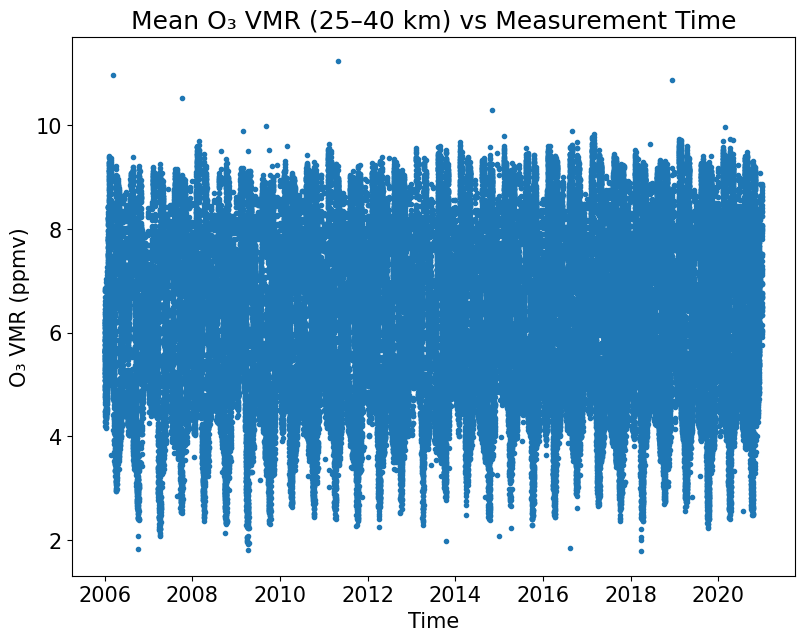

In [17]:
(O3_times * 10**6).sel(altitude = slice(25, 40)).mean(dim = "altitude").plot(marker = ".", linestyle = "None", size = 7)

plt.ylabel("O₃ VMR (ppmv)")
plt.xlabel("Time")
plt.title("Mean O₃ VMR (25–40 km) vs Measurement Time")

fig = plt.gcf()
axes = plt.gca()

title = axes.get_title()
fig.savefig(title, bbox_inches="tight")

c:\Program Files\Python312\Lib\site-packages\xarray\groupers.py:498: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


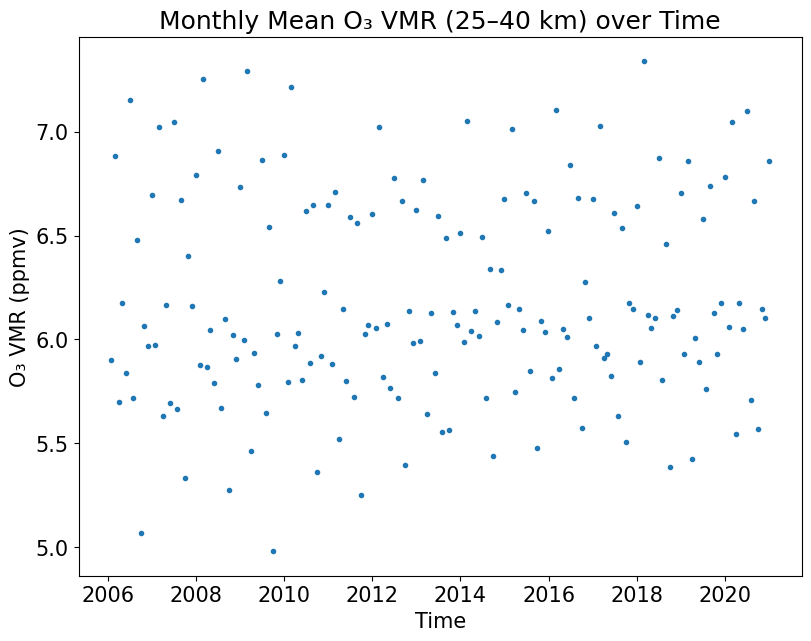

In [18]:
(O3_times * 10**6).sel(altitude = slice(25, 40)).resample(time = "1M").mean(dim = ["altitude", "time"]).plot(marker = ".", linestyle = "None", size = 7)

plt.ylabel("O₃ VMR (ppmv)")
plt.xlabel("Time")
plt.title("Monthly Mean O₃ VMR (25–40 km) over Time")

fig = plt.gcf()
axes = plt.gca()

title = axes.get_title()
fig.savefig(title, bbox_inches="tight")

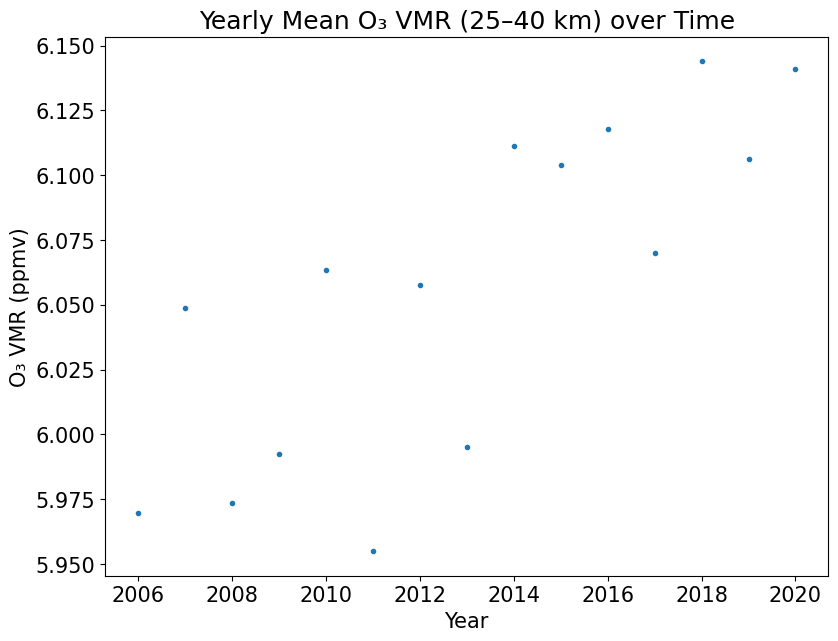

In [19]:
(O3_times * 10**6).sel(altitude = slice(25, 40)).groupby("time.year").mean(dim = ["altitude", "time"]).plot(marker = ".", linestyle = "None", size = 7)

plt.ylabel("O₃ VMR (ppmv)")
plt.xlabel("Year")
plt.title("Yearly Mean O₃ VMR (25–40 km) over Time")

fig = plt.gcf()
axes = plt.gca()

title = axes.get_title()
fig.savefig(title, bbox_inches="tight")

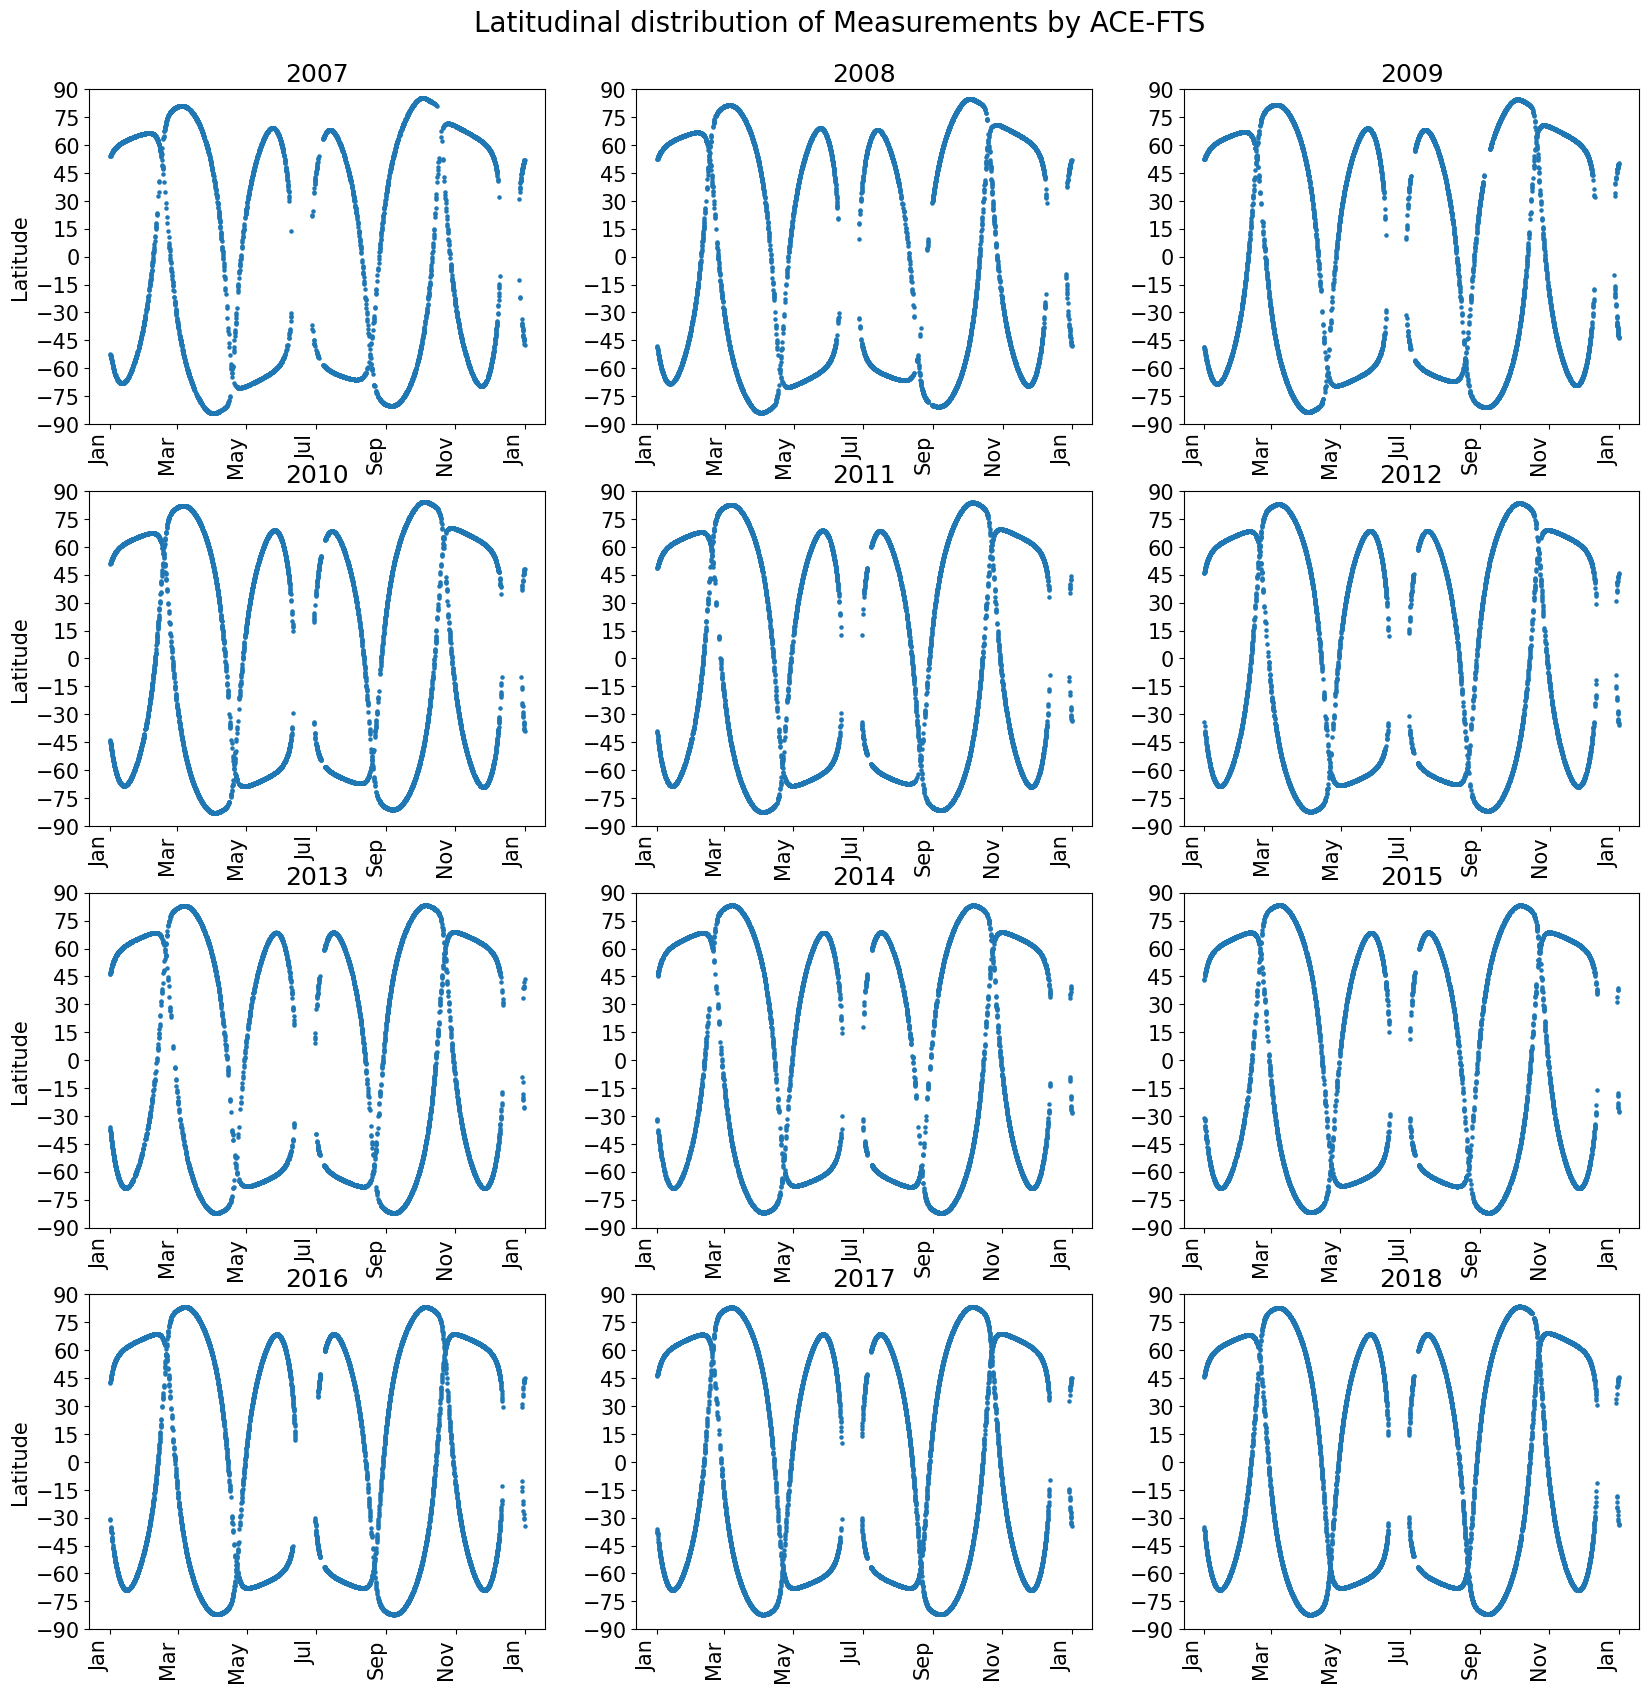

In [ ]:
fig, axes = plt.subplots(4, 3, figsize = (20, 20))

years = [str(i) for i in range(2007, 2019)]

import matplotlib.dates as mdates

for idx, year in enumerate(years):
    ax = axes.flat[idx]
    ax.scatter(O3_times.sel(time = slice(year + "-01-01", year + "-12-31")).time, O3_times.sel(time = slice(year + "-01-01", year + "-12-31")).latitude, s = 5)
    ax.set_title(year)
    
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1,3,5,7,9,11]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

    plt.setp(ax.get_xticklabels(), rotation=90, ha='right')
    ax.set_ylim(-90, 90)
    ax.set_yticks(np.arange(-90, 91, 15))

fig = plt.gcf()

plt.suptitle(
    "Latitudinal distribution of Measurements by ACE-FTS", 
    fontsize=20,
    y=0.92
)

axes.flat[0].set(ylabel = "Latitude")
axes.flat[9].set(ylabel = "Latitude")
axes.flat[6].set(ylabel = "Latitude")
axes.flat[3].set(ylabel = "Latitude")

title = fig._suptitle.get_text()
fig.savefig(title, bbox_inches="tight")

C:\Users\salla\AppData\Local\Temp\ipykernel_3048\2706481341.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.88, 0.93])


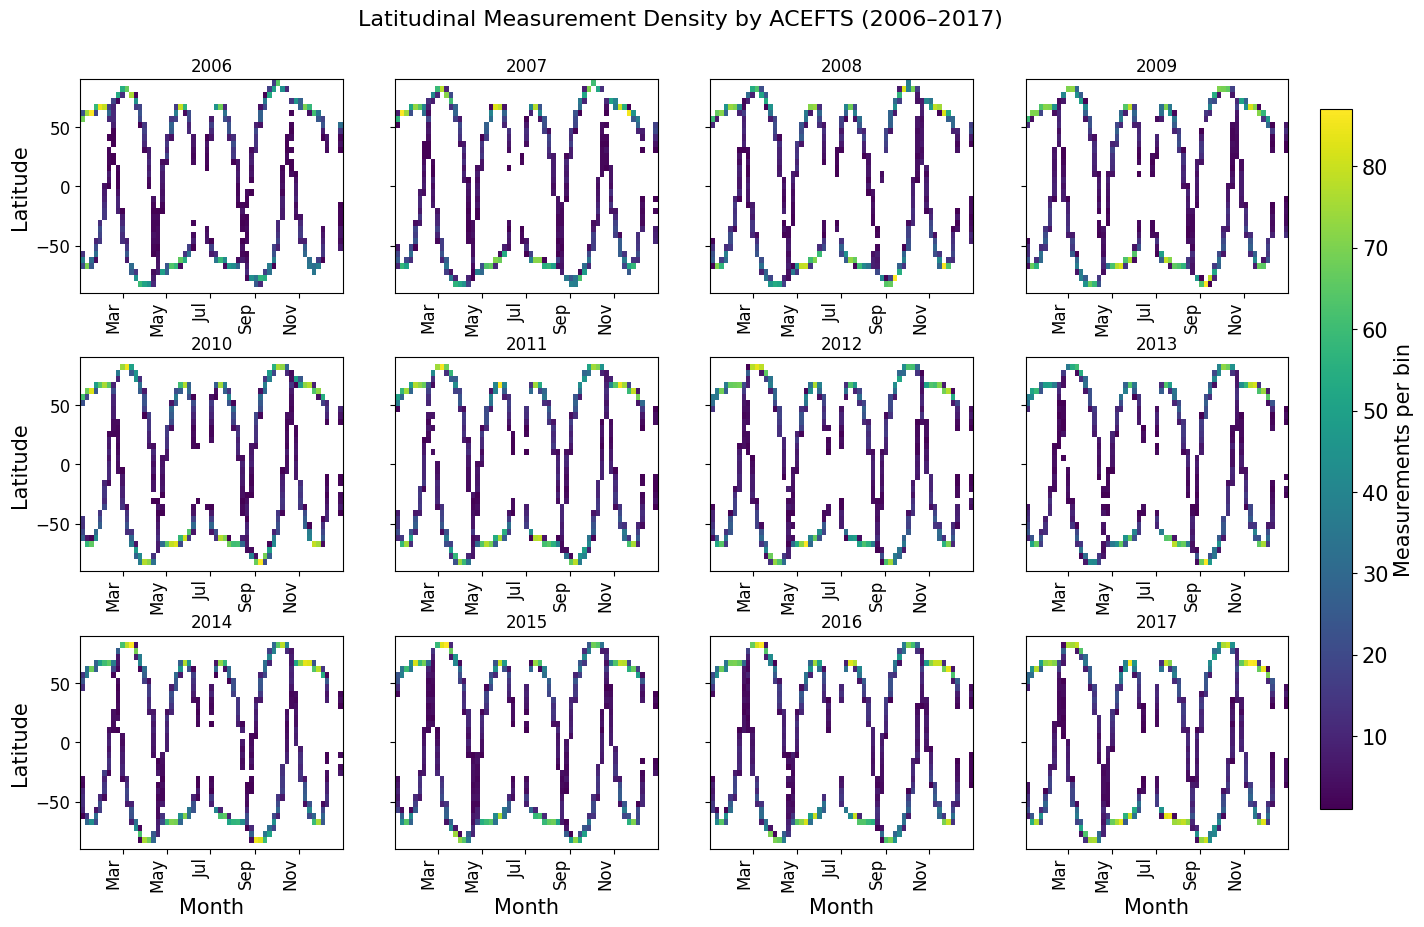

In [ ]:
import matplotlib.dates as mdates

years = list(range(2006, 2018))
fig, axes = plt.subplots(
    nrows=3, ncols=4,
    figsize=(16, 10),
    sharey=True,
    gridspec_kw={'right': 0.88, 'hspace': 0.3, 'wspace': 0.2}
)
axes = axes.flatten()

for i, year in enumerate(years):
    ax = axes[i]
    sel = O3_times.sel(time=slice(f"{year}-01-01", f"{year}-12-31"))
    tnum = mdates.date2num(sel.time)

    time_bins = np.linspace(tnum.min(), tnum.max(), 60)
    lat_bins  = np.linspace(-90, 90, 36)
    H, tx, ly = np.histogram2d(tnum, sel.latitude.values, bins=[time_bins, lat_bins])
    H = H.T
    H_mask = np.ma.masked_where(H == 0, H)

    cmap = plt.get_cmap('viridis').copy()
    cmap.set_bad(color='white')

    mesh = ax.pcolormesh(tx, ly, H_mask, shading='auto', cmap=cmap)

    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth = [1, 3, 5, 7, 9, 11]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.tick_params(axis='x', labelsize=12, rotation=90, pad=2)
    ax.tick_params(axis='y', labelsize=12)
    plt.setp(ax.get_xticklabels(), rotation=90, ha='right')
    ax.set_ylim(-90, 90)
    ax.set_title(str(year), fontsize=12)
    if i % 4 == 0: ax.set_ylabel("Latitude")
    if i >= 8:    ax.set_xlabel("Month")

cax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
cb = fig.colorbar(mesh, cax=cax)
cb.set_label('Measurements per bin')

plt.tight_layout(rect=[0, 0, 0.88, 0.93])
plt.suptitle("Latitudinal Measurement Density by ACEFTS (2006–2017)", fontsize=16, y=0.95)

title = fig._suptitle.get_text()
fig.savefig(title, bbox_inches="tight")

In [ ]:
import sys
sys.path.extend([
    r"C:\Users\salla\Onedrive(uoft acc)\OneDrive - University of Toronto\Desktop\School Information\NSERC\NSERC\OSIRIS"])
import OSIRIS_helper as OSIRIS

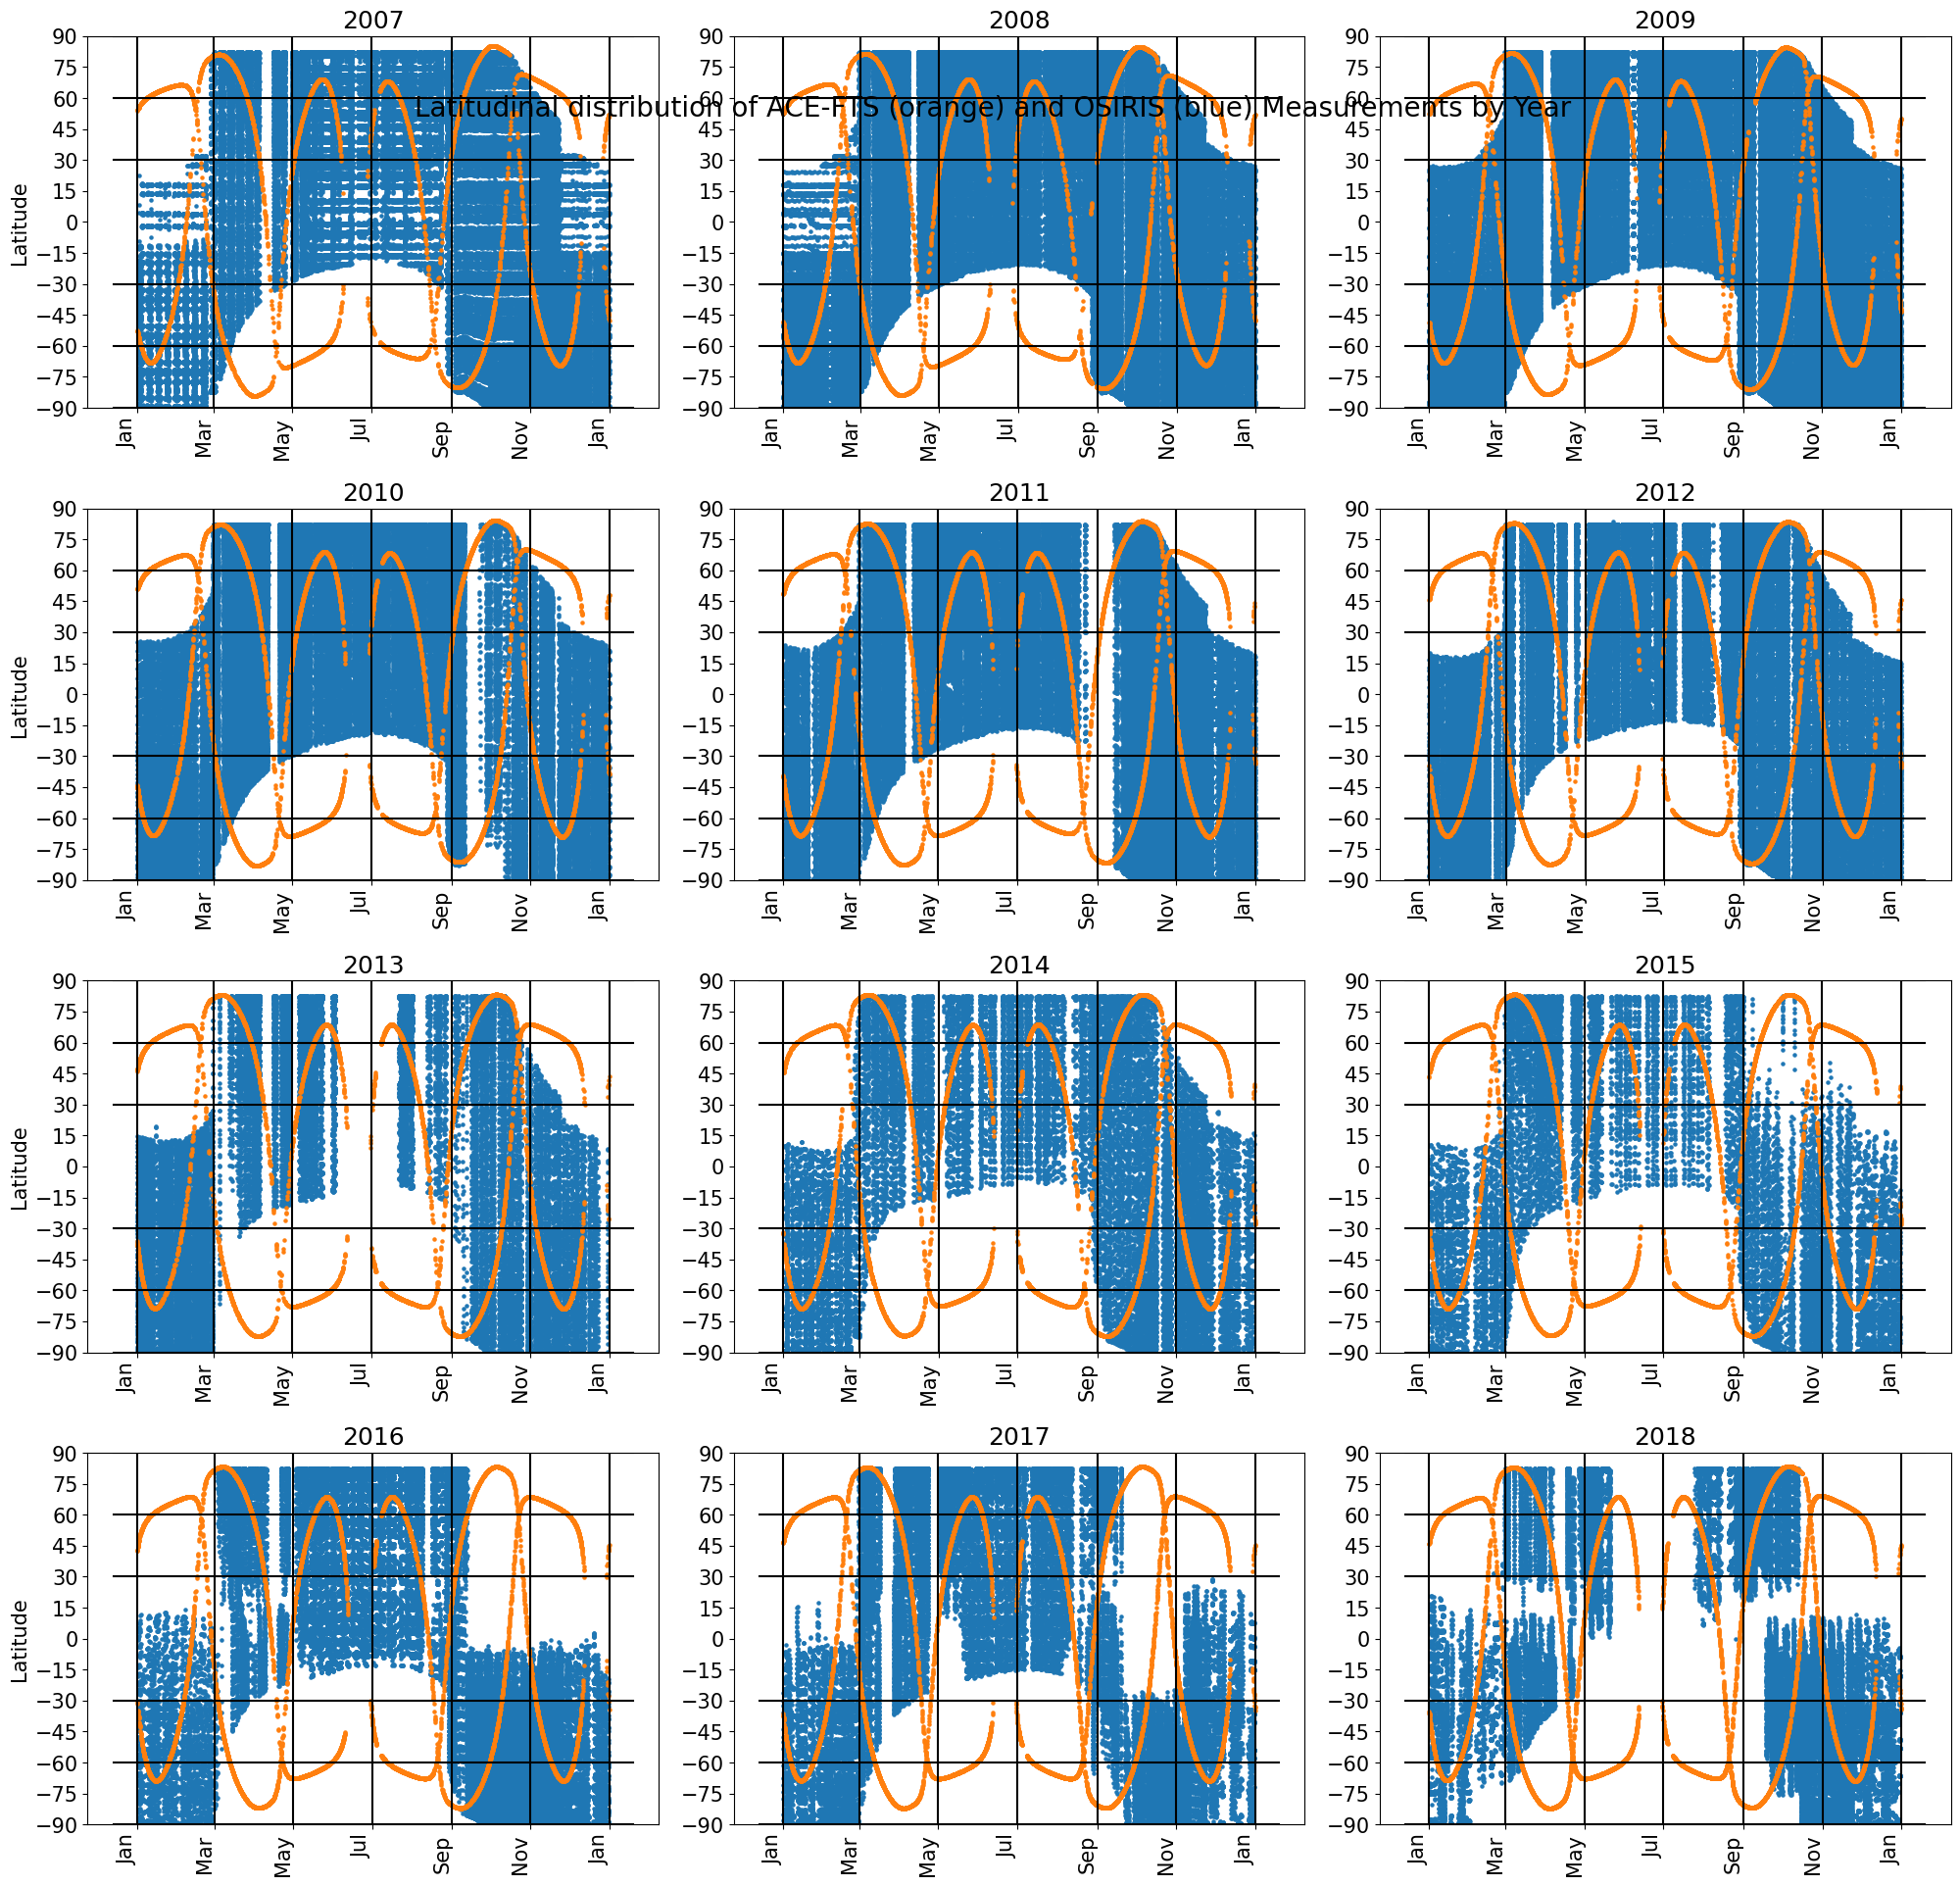

In [ ]:
fig, axes = plt.subplots(4, 3, figsize = (20, 20))

years = [str(i) for i in range(2007, 2019)]

import matplotlib.dates as mdates

for idx, year in enumerate(years):
    ax = axes.flat[idx]

    OSIRIS_O3_times = OSIRIS.get_time_filtered_vmr(OSIRIS.get_vmr(), year + "-01-01", year + "-12-31")
    ax.scatter(OSIRIS_O3_times.sel(time = slice(year + "-01-01", year + "-12-31")).time, OSIRIS_O3_times.sel(time = slice(year + "-01-01", year + "-12-31")).latitude, s = 5, color = "tab:blue")

    ax.scatter(O3_times.sel(time = slice(year + "-01-01", year + "-12-31")).time, O3_times.sel(time = slice(year + "-01-01", year + "-12-31")).latitude, s = 5, color = "tab:orange")
    ax.set_title(year)
    
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1,3,5,7,9,11]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

    plt.setp(ax.get_xticklabels(), rotation=90, ha='right')
    ax.set_ylim(-90, 90)
    ax.set_yticks(np.arange(-90, 91, 15))

    xlims = ax.get_xlim()
    for j in [90, 60, 30, -30, -60, -90]:
        ax.plot(list(xlims), [j, j], color = "black")
    
    ylims = ax.get_ylim()
    for tick in ax.xaxis.get_majorticklocs():
        ax.plot([tick, tick], list(ylims), color = "black")

fig = plt.gcf()

plt.suptitle(
    "Latitudinal distribution of ACE-FTS (orange) and OSIRIS (blue) Measurements by Year", 
    fontsize=20,
    y=0.95
)

plt.tight_layout()

axes.flat[0].set(ylabel = "Latitude")
axes.flat[9].set(ylabel = "Latitude")
axes.flat[6].set(ylabel = "Latitude")
axes.flat[3].set(ylabel = "Latitude")

title = fig._suptitle.get_text()
fig.savefig(title, bbox_inches="tight")